Team H: Crime (Parking Citations)

Jeffrey Kuo, Thipbadee Tantivilaisin, Bryan Wang, Tessa Weiss

# Loading Packages

In [38]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import random
import ipywidgets as widgets # for dropdown
import folium
from matplotlib.pyplot import figure

# Read in the Data

We are using a subset of the parking violations data, specifically just the data from 2022-2023 since the original file is extremely large. Here, we read in and reformat the data, turning it into a GeoDataFrame in order to create map plots later on, as well as add an additional column specifying the day of the week of each citation.

In [39]:
# reading in data and visualizing first few rows

df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

Citation Number Citation Issued DateTime  Violation Violation Description  \
0       950226616      2022-04-20 12:10:00  TRC7.2.22             STR CLEAN   
1       952126114      2022-06-17 16:12:00  TRC7.2.20                RES/OT   
2       950441903      2022-04-23 15:13:00      V5200             NO PLATES   
3       948460144      2022-02-22 11:54:00  TRC7.2.20                RES/OT   
4       948169644      2022-02-17 13:39:00  TRC7.2.20                RES/OT   

  Citation Location Vehicle Plate State Vehicle Plate  Fine Amount  \
0   1318 FILBERT ST                  CA       V507699         84.0   
1   1318 FILBERT ST                  CA       BV44D97         96.0   
2   1318 FILBERT ST                  CA       V507699        121.0   
3   1318 FILBERT ST                  TX       HVT6737         96.0   
4   1318 FILBERT ST                  OH       HQA6554         96.0   

               Date Added                                            geom  
0  05/01/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
1  07/17/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
2  05/18/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
3  05/23/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)  
4  04/03/2022 12:00:00 AM  POINT (-122.42119800399996 37.800016984000024)

In [40]:
# converts to GeoDataFrame for map plots. takes about 30 seconds

df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [41]:
# converting to datetime

df['Citation Issued DateTime'] = pd.to_datetime(df['Citation Issued DateTime'])

In [42]:
# add a column for just day

df['citation_day'] = df['Citation Issued DateTime'].dt.day_name()

In [43]:
# having consistency in street name

for r in (("BOULEVARD", "BLVD"), ("STREET", "ST"), ('AVENUE', 'AVE')):
    df['Citation Location'] = df['Citation Location'].str.replace(*r, regex = True)

# Basic EDA

## Exploring number of tickets relative to different time scales

### Number of tickets per month:
First, we make a plot of the number of citations factored by each month of the year.

In [44]:
# changing default resolution of plots to be higher
plt.rcParams['figure.dpi'] = 125

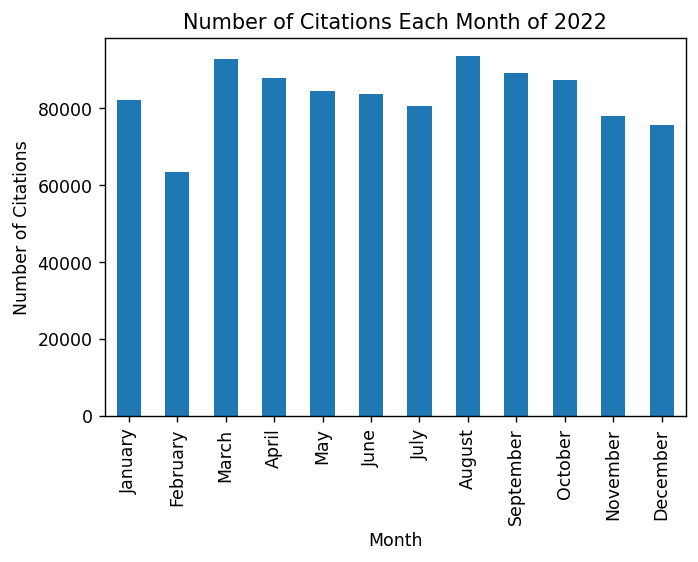

In [45]:
# tickets by month

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# only look at 2022 data
df2022 = df[df['Citation Issued DateTime'] < pd.to_datetime('2022-12-31')]

# plot
df2022['Citation Issued DateTime'].dt.month_name().value_counts().loc[months].plot.bar()
plt.xlabel("Month")
plt.ylabel("Number of Citations")
plt.title("Number of Citations Each Month of 2022");

We see that the number of citations is highest in March, steadily decreasing until fall. This trend repeats from August to December.

### Number of tickets by day of the week:
The second plot shows the number of citations factored by each day of the week.

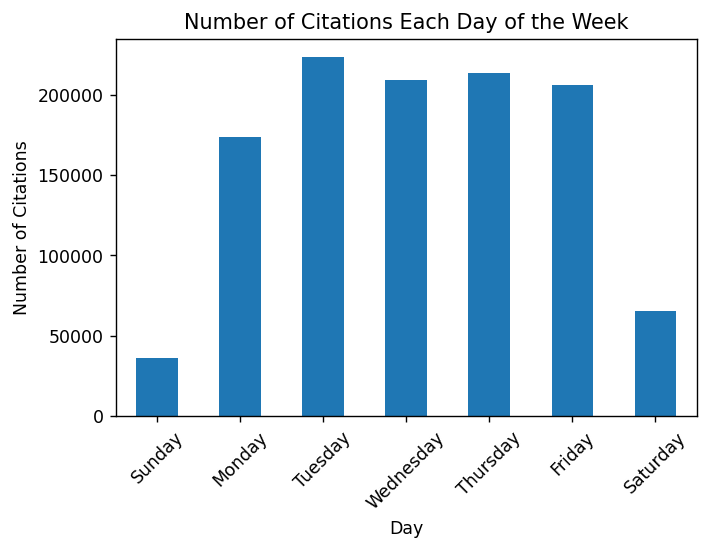

In [46]:
# tickets by day of the week

days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
ax = df['Citation Issued DateTime'].dt.day_name().value_counts().loc[days].plot.bar()
#ax.bar_label(ax.containers[0])
plt.xlabel("Day")
plt.ylabel("Number of Citations")
plt.title("Number of Citations Each Day of the Week")
plt.xticks(rotation=45);

There are noticably less citations on the weekends, as well as on Mondays. This may be due to free parking on the weekends, and the fact that street cleaning usually occurs during the week (we see later that street cleaning is the most common parking violation).

### Number of tickets by hour of the day:
Finally, we plot the number eof citations factored by each hour of the day (0 = 12am, 1 = 1am, etc.).

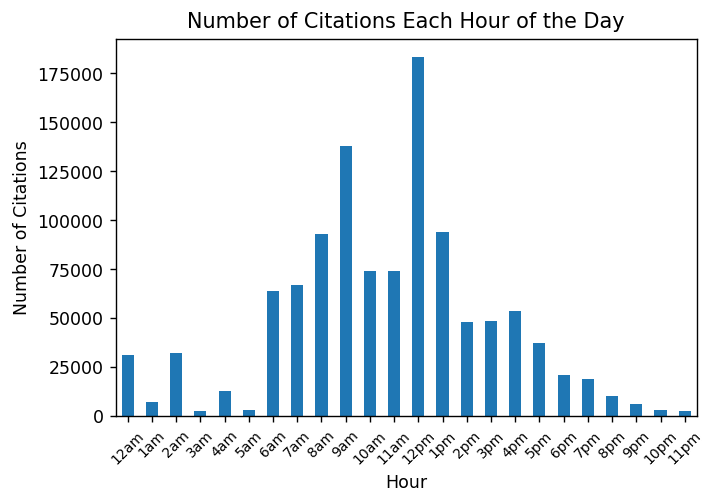

In [47]:
# tickets by hour of the day

ax = df['Citation Issued DateTime'].dt.hour.value_counts().loc[range(0, 24)].plot.bar()
plt.xlabel("Hour")
plt.ylabel("Number of Citations")
plt.title("Number of Citations Each Hour of the Day");
hour = ["12am", "1am", "2am", "3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
        "12pm", "1pm", "2pm", "3pm", "4pm", "5pm", "6pm", "7pm", "8pm", "9pm", "10pm", "11pm"]
ax.set_xticklabels(hour)
plt.xticks(rotation=45, fontsize = 8);

There are huge spikes of parking violations occurring at 9:00am and 12:00pm, which correspond to the times when people typically get to work or park for lunch, so these trends make sense.

We can look at another perspective of the third plot by creating a line plot that shows of the number of citations per day in the month of January:

/Users/timtan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


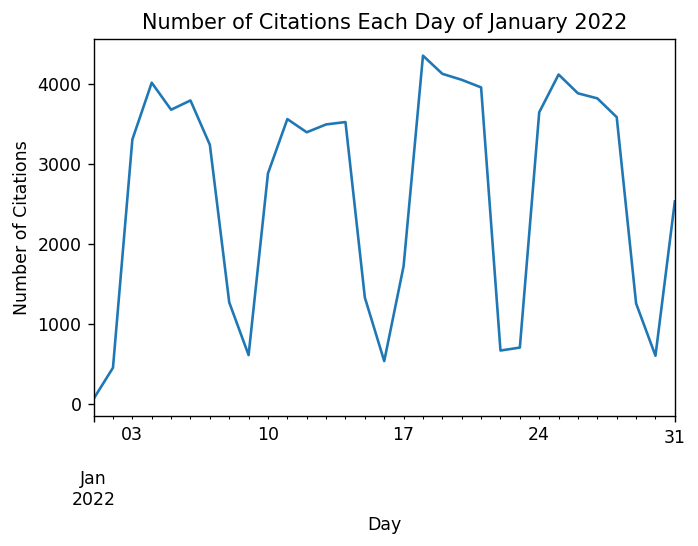

In [48]:
# plot number of citations by day

num_citations_day = df['Citation Issued DateTime'].dt.date.value_counts()
jan_citations = num_citations_day[num_citations_day.index < pd.to_datetime('2022-02-01')]
new_idx = pd.date_range(min(jan_citations.index), max(jan_citations.index))
jan_citations.reindex(new_idx, fill_value=0).plot(kind='line')
plt.xlabel("Day")
plt.ylabel("Number of Citations")
plt.title("Number of Citations Each Day of January 2022");

Here, we see a cyclic trend throughout each week. We see that the large dips correspond to the weekends, and the peaks in each cycle correspond to Tuesdays. We saw these same trends in the previous plot of tickets by day of the week.

## Exploring the most common violations

We now attempt to find the most common parking violations and see which cars committed these violations, as well as plot a map of where the most common citations occur to see if there is a trend.

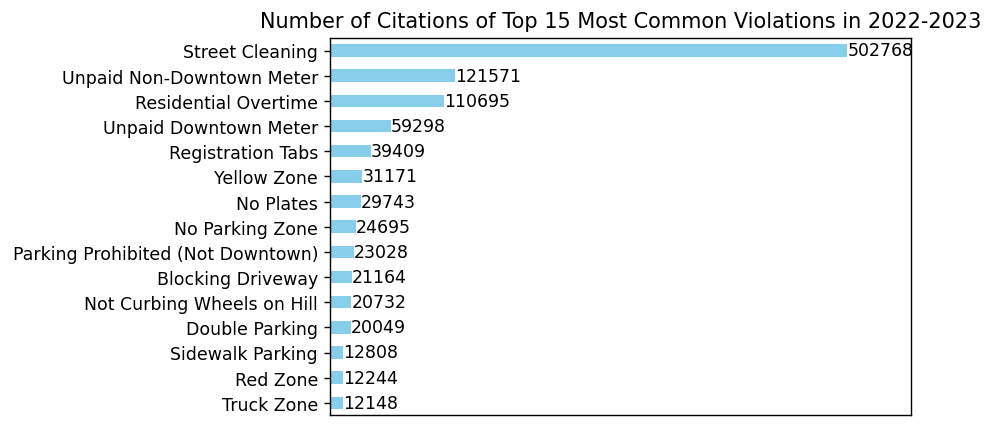

In [49]:
# bar plot of top 15 most common violation frequencies in descending order, with corresponding percentages

df_com = df

# changing violation descriptions to words
df_com.loc[df_com["Violation Description"] == "METER DTN", "Violation Description"] = "Unpaid Downtown Meter"
df_com.loc[df_com["Violation Description"] == "MTR OUT DT", "Violation Description"] = "Unpaid Non-Downtown Meter"
df_com.loc[df_com["Violation Description"] == "PRK PROHIB", "Violation Description"] = "No Parking Zone"
df_com.loc[df_com["Violation Description"] == "STR CLEAN", "Violation Description"] = "Street Cleaning"
df_com.loc[df_com["Violation Description"] == "DRIVEWAY", "Violation Description"] = "Blocking Driveway"
df_com.loc[df_com["Violation Description"] == "NO PLATES", "Violation Description"] = "No Plates"
df_com.loc[df_com["Violation Description"] == "PK PHB OTD", "Violation Description"] = "Parking Prohibited (Not Downtown)"
df_com.loc[df_com["Violation Description"] == "YEL ZONE", "Violation Description"] = "Yellow Zone"
df_com.loc[df_com["Violation Description"] == "RES/OT", "Violation Description"] = "Residential Overtime"
df_com.loc[df_com["Violation Description"] == "REG TABS", "Violation Description"] = "Registration Tabs"
df_com.loc[df_com["Violation Description"] == "PRK GRADE", "Violation Description"] = "Not Curbing Wheels on Hill"
df_com.loc[df_com["Violation Description"] == "DBL PARK", "Violation Description"] = "Double Parking"
df_com.loc[df_com["Violation Description"] == "ON SIDEWLK", "Violation Description"] = "Sidewalk Parking"
df_com.loc[df_com["Violation Description"] == "RED ZONE", "Violation Description"] = "Red Zone"
df_com.loc[df_com["Violation Description"] == "TRK ZONE", "Violation Description"] = "Truck Zone"
df_com.loc[df_com["Violation Description"] == "WHITE ZONE", "Violation Description"] = "White Zone"
df_com.loc[df_com["Violation Description"] == "OT OUT DT", "Violation Description"] = "Overtime Parking (Not Downtown)"
df_com.loc[df_com["Violation Description"] == "PK STANDS", "Violation Description"] = "Parking in Stand"
df_com.loc[df_com["Violation Description"] == "BLK BIKE L", "Violation Description"] = "Bicycle Path/Lane"
df_com.loc[df_com["Violation Description"] == "OBSTRCT TF", "Violation Description"] = "Obstructing Traffic"


ax = df_com['Violation Description'].value_counts().head(n=15).iloc[::-1].plot(kind='barh', color = "skyblue")
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_xticks([])
plt.xlim(0, 565000)
#plt.xlabel("Violation Description")
plt.ylabel("")
plt.title("Number of Citations of Top 15 Most Common Violations in 2022-2023");

In [50]:
# percentages
df['Violation Description'].value_counts(normalize=True)

Street Cleaning              4.458400e-01
Unpaid Non-Downtown Meter    1.078056e-01
Residential Overtime         9.816110e-02
Unpaid Downtown Meter        5.258374e-02
Registration Tabs            3.494675e-02
                                 ...     
FR/EVA/YTH                   8.867709e-07
SAFETY ZN                    8.867709e-07
SPITTING                     8.867709e-07
NO STOP BP                   8.867709e-07
CAR ALM/EM                   8.867709e-07
Name: Violation Description, Length: 116, dtype: float64

By far, the largest parking violation is parking during street cleaning, making up 44.5% of all parking violations. MTR OUT DT refers to a ticket received for not paying for the meter in a non-downtown location, which accounts for the next 10.8% of parking violations, with RES/OT (illegally parking in a residential area) accounting for the next 9.8%.

Now, we find the 10 vehicle plates that received the most parking tickets and try to see if there is any similarities in the committed violations.

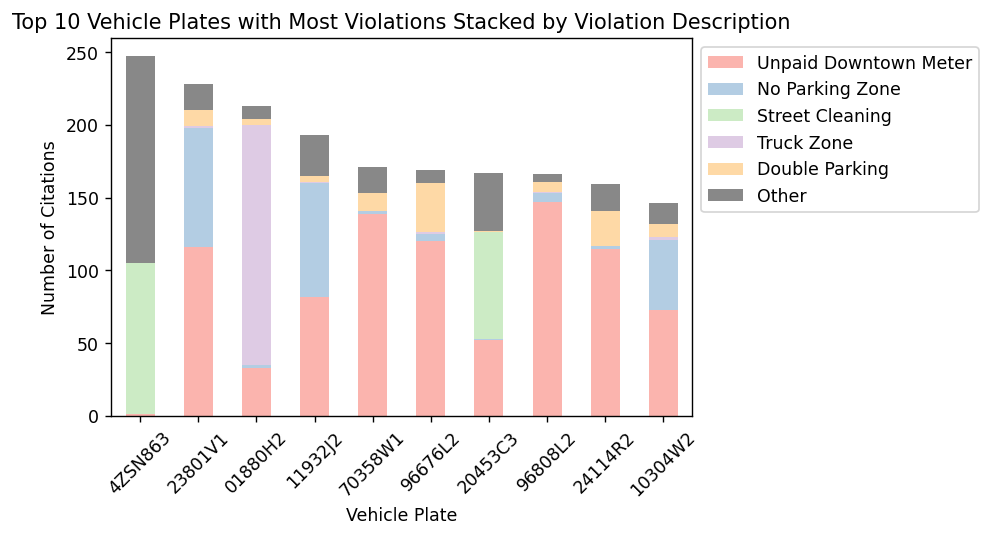

In [51]:
# top 10 people with most citations and their most common citation descriptions

# dataframe filtered to the info with top 10 vehicles
top_plates = df[df["Vehicle Plate"].isin(df["Vehicle Plate"].value_counts().head(10).index.tolist())]
top_plates = top_plates[["Vehicle Plate", "Violation Description"]]

# renaming top violations to readable words
top_plates.loc[top_plates["Violation Description"] == "METER DTN", "Violation Description"] = "Unpaid Downtown Meter"
top_plates.loc[top_plates["Violation Description"] == "PRK PROHIB", "Violation Description"] = "No Parking Zone"
top_plates.loc[top_plates["Violation Description"] == "STR CLEAN", "Violation Description"] = "Street Cleaning"
top_plates.loc[top_plates["Violation Description"] == "TRK ZONE", "Violation Description"] = "Truck Zone"
top_plates.loc[top_plates["Violation Description"] == "DBL PARK", "Violation Description"] = "Double Park"


# list of unique violation descriptions, cats_top = top 5 most common, cat_others = all others
cats_all = top_plates["Violation Description"].unique().tolist()
cats_top = top_plates["Violation Description"].value_counts().index.tolist()[0:5]
cats_other = [x for x in cats_all if x not in cats_top]

# setting all descriptions not in the top 5 to "other"
top_plates.loc[top_plates["Violation Description"].isin(cats_other), "Violation Description"] = "Other"
cats = cats_top + ["Other"]

plates = pd.crosstab(top_plates['Vehicle Plate'], pd.Categorical(top_plates['Violation Description'], categories=cats, ordered=True))
plates = pd.crosstab(top_plates['Vehicle Plate'], top_plates['Violation Description']).reindex(columns=cats).reset_index()

# creating colors
color = ["#FBB4AE", "#B3CDE3", "#CCEBC5", "#DECBE4", "#FED9A6", "#888888"]

# order of plates from highest amount of citations to lowest
ord = df["Vehicle Plate"].value_counts().head(10).index.tolist()

plates.set_index("Vehicle Plate").loc[ord].plot(kind='bar', stacked=True,
        title='Top 10 Vehicle Plates with Most Violations Stacked by Violation Description', color = color)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Number of Citations")
plt.xticks(rotation=45)
plt.show()


We can see the majority of the cars in this plot were most affected by downtown meter violations, so there is a commonality here. In general, each car has a large majority of tickets in one specific area. It is also interesting to note that one person received almost 250 tickets in a single year!

To further explore at the per car level, we would like to find the distribution of tickets allocated to each car.

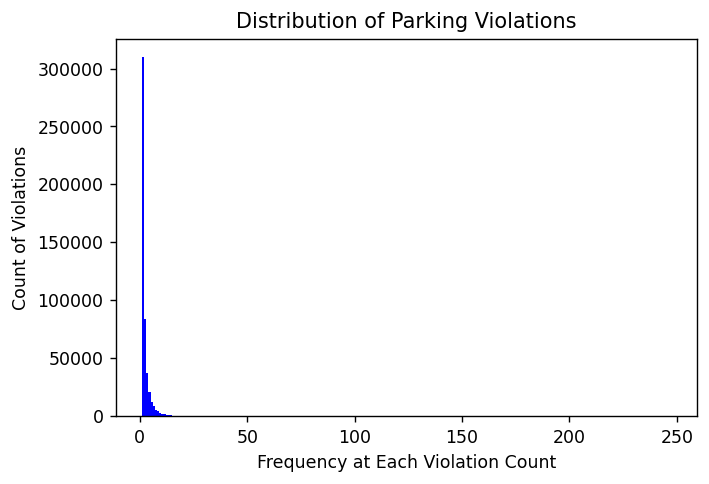

In [52]:
# aggregating by unique Plate with counts
df_dist = df.groupby(['Vehicle Plate']).size().reset_index(name='Number of Violations Per Plate')

# creating the histogram
num_bins = df_dist['Number of Violations Per Plate'].max()
plt.hist(df_dist['Number of Violations Per Plate'], color = 'blue', bins = num_bins )
plt.title('Distribution of Parking Violations');
plt.xlabel('Frequency at Each Violation Count');
plt.ylabel('Count of Violations');

This will likely be easier seen on a table.

In [53]:
# create a new df with number of violations per plate and count 
df_num_vio = df_dist.groupby(['Number of Violations Per Plate']).size().reset_index(name='Number of Violations by Count')

# group the dataframe by Number of Violations Per Plate greater than 10 and aggregate the counts
grouped_df = df_num_vio.groupby(df_num_vio['Number of Violations Per Plate'] > 10).agg({'Number of Violations Per Plate': 'sum', 'Number of Violations by Count': 'sum'})

# create a new row for the aggregated counts and integer
new_row = {'Number of Violations Per Plate': 'greater than 10', 'Number of Violations by Count': grouped_df.loc[True, 'Number of Violations by Count']}
grouped_df = pd.concat([grouped_df.loc[False], pd.DataFrame([new_row])])

# drop the rows where Integer is greater than 10
df_num_vio = df_num_vio.loc[df_num_vio['Number of Violations Per Plate'] <= 10]

# append the aggregated row to the dataframe
df_num_vio = pd.concat([df_num_vio, pd.DataFrame([new_row])], ignore_index=True)

# compute the sum of the counts for each value of "Number of Violations Per Plate"
counts_per_plate = df_num_vio['Number of Violations by Count'].sum()

# compute the percentage of the total count for each value of "Number of Violations Per Plate"
df_num_vio['Percentage of Total Violations'] = df_num_vio['Number of Violations by Count'] / counts_per_plate * 100

df_num_vio

Number of Violations Per Plate  Number of Violations by Count  \
0                               1                         310034   
1                               2                          84258   
2                               3                          37558   
3                               4                          21031   
4                               5                          12804   
5                               6                           8579   
6                               7                           5884   
7                               8                           4283   
8                               9                           3213   
9                              10                           2413   
10                greater than 10                          10909   

    Percentage of Total Violations  
0                        61.887234  
1                        16.819105  
2                         7.497116  
3                         4.198089  
4                         2.555862  
5                         1.712491  
6                         1.174531  
7                         0.854948  
8                         0.641361  
9                         0.481669  
10                        2.177593

We can see that the majority of cars will only ever get one violation in that year, with 61.89%.

Next, we create a map showing the geographical location of the citations for the top 10 most common violations.

In [54]:
# map of where top 10 most common violations occurred

top10_vio = df["Violation Description"].value_counts().head(10).index.tolist()
df_top10 = df[df["Violation Description"].isin(top10_vio)]
df_top10 = df_top10.loc[:, df_top10.columns != "Citation Issued DateTime"]

# changing violation descriptions to words
df_top10.loc[df_top10["Violation Description"] == "METER DTN", "Violation Description"] = "Unpaid Downtown Meter"
df_top10.loc[df_top10["Violation Description"] == "MTR OUT DT", "Violation Description"] = "Unpaid Non-Downtown Meter"
df_top10.loc[df_top10["Violation Description"] == "PRK PROHIB", "Violation Description"] = "No Parking Zone"
df_top10.loc[df_top10["Violation Description"] == "STR CLEAN", "Violation Description"] = "Street Cleaning"
df_top10.loc[df_top10["Violation Description"] == "DRIVEWAY", "Violation Description"] = "Blocking Driveway"
df_top10.loc[df_top10["Violation Description"] == "NO PLATES", "Violation Description"] = "No Plates"
df_top10.loc[df_top10["Violation Description"] == "PK PHB OTD", "Violation Description"] = "Parking Prohibited (Not Downtown)"
df_top10.loc[df_top10["Violation Description"] == "YEL ZONE", "Violation Description"] = "Yellow Zone"
df_top10.loc[df_top10["Violation Description"] == "RES/OT", "Violation Description"] = "Residential Overtime"
df_top10.loc[df_top10["Violation Description"] == "REG TABS", "Violation Description"] = "Registration Tabs"

# explore map
color = ["#A5AA99", "#F97B72", "#19D3F3", "#8C564B", "#E68310", "#80BA5A", "#E73F74", "#F2B701", "#3969AC", "#11A579", "#7F3C8D"]
df_top10.sample(10000).explore("Violation Description", cmap = color)



In [55]:
df.loc[df["Violation Description"] == "PK PHB OTD",:]

Empty GeoDataFrame
Columns: [Citation Number, Citation Issued DateTime, Violation, Violation Description, Citation Location, Vehicle Plate State, Vehicle Plate, Fine Amount, Date Added, geom, citation_day]
Index: []

From the map, we see an overwhelming amount of street cleaning tickets spread throughout San Francisco. We also notice a really interesting trend in the meter tickets for non-downtown areas. It almost appears as though the citations follow a few straight lines through some big streets. Maybe these larger streets have stricter parking enforcement.

## Exploring the most citations by location

In this section, we find the locations with the largest amounts of parking citations, creating a bar plot as well as a neighborhood map.

In [56]:
# top 10 areas with the most citations

num_citations_by_location = df['Citation Location'].value_counts()
gb_first = df.groupby('Citation Location').nth(0)

citation_df = gpd.GeoDataFrame(pd.merge(num_citations_by_location, gb_first, left_index=True, right_on='Citation Location'), geometry='geom')
citation_df.rename({'Citation Location': 'citation_count'}, axis=1, inplace=True)
citation_df.head(n=10)['citation_count']

Citation Location
501 TERRY A FRANCOIS BLVD    1830
993 POTRERO AVE               589
200 CHANNEL ST                581
492 CASTRO ST                 519
100 SPEAR ST                  444
300 FREMONT ST                420
3252 PIERCE ST                380
1001 POTRERO AVE              352
EMBARCADERO STATION           343
500 HOWARD ST                 336
Name: citation_count, dtype: int64

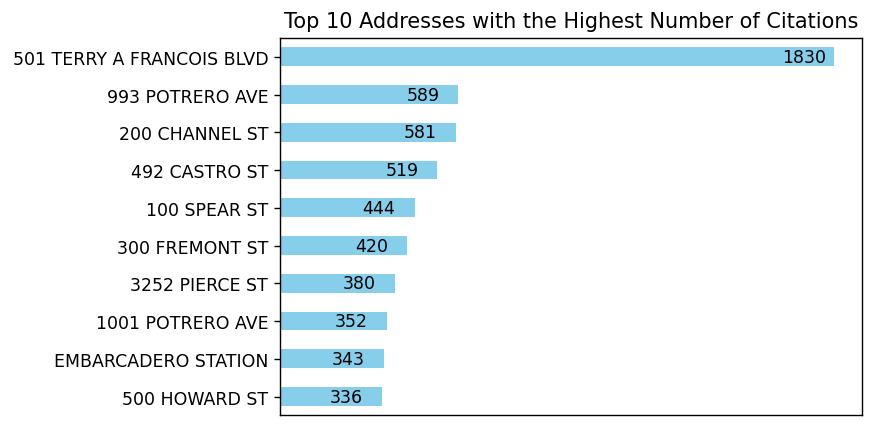

In [57]:
# bar plot of top 10 areas with the most citations

ax = citation_df.head(n=10).iloc[::-1]['citation_count'].plot(kind='barh', color = "skyblue")
ax.bar_label(ax.containers[0], label_type="edge", padding = -30)
ax.set_xticks([])
plt.ylabel("")
#plt.xlabel("Number of Citations")
plt.title("Top 10 Addresses with the Highest Number of Citations");



The location with the largest number of citations has more than double the number of citations as the next highest!

Now, we'll analyze the number of citations in different neighborhoods in San Francisco by loading in the neighborhoods file.

In [58]:
# top 20 neighborhoods with most citations. takes about 47 seconds

neighborhoods = gpd.read_file('../data/sf_neighborhoods.geojson')
citation_neighborhoods = df.sjoin(neighborhoods, how="left")
citation_neighborhoods.name.value_counts().head(n=20)

Mission                    80375
South of Market            70411
Tenderloin                 48711
Pacific Heights            38891
Financial District         37721
Lower Nob Hill             30624
Outer Richmond             26899
Outer Sunset               26512
Potrero Hill               26136
Marina                     24382
Inner Richmond             23386
Mission Bay                22371
Northern Waterfront        20641
Civic Center               20099
North Beach                20060
Union Street               19844
Mission Dolores            18874
Noe Valley                 18306
Downtown / Union Square    18006
Dolores Heights            17545
Name: name, dtype: int64

In [59]:
# map of citations in each neighboorhood

n_df = neighborhoods.set_index('name')
n_df['num_citations'] = citation_neighborhoods.name.value_counts()
n_df.explore(column='num_citations')

From the map, we see that the Mission and South of Market neighborhoods have far more citations than any other, with the Tenderloin and Pacific Heights following. All of these neighborhoods appear to be rather close together on the map, suggesting parking may be enforced more harshly in this designated area.

## Exploring Revenue

Now, we analyze the amount of money being made from parking tickets. We will first look at the total revenue generated from all parking citations.

In [60]:
# total revenue from all tickets (in dollars):

df['Fine Amount'].sum()

108067177.0

Next, we look at a time series plot of the total daily fines from 2022-2023. 

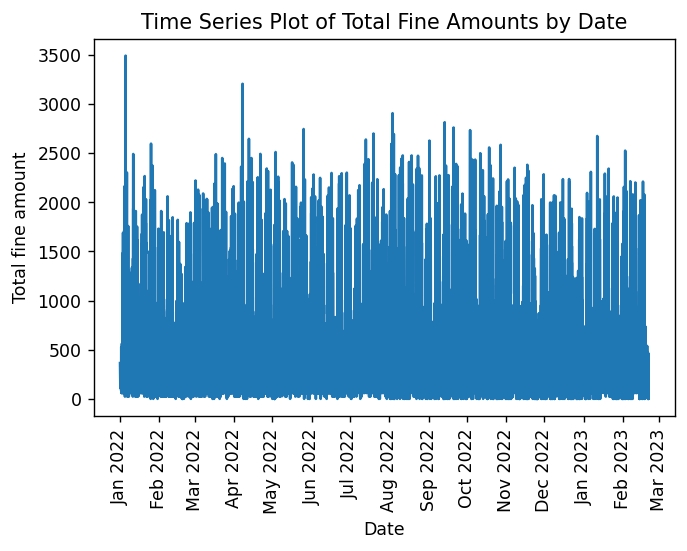

In [61]:
# time series plot of fines from 2022-2023

# Group data by date and sum the fine amounts
grouped_data = df.groupby('Citation Issued DateTime')['Fine Amount'].sum()

# Plot the time series
fig, ax = plt.subplots()
ax.plot(grouped_data.index, grouped_data.values)

# Set x-axis tick locator and formatter for months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total fine amount')
plt.title('Time Series Plot of Total Fine Amounts by Date')
plt.xticks(rotation=90)
plt.show()

This plot looks a little messy, so instead we'll look at the monthly average.

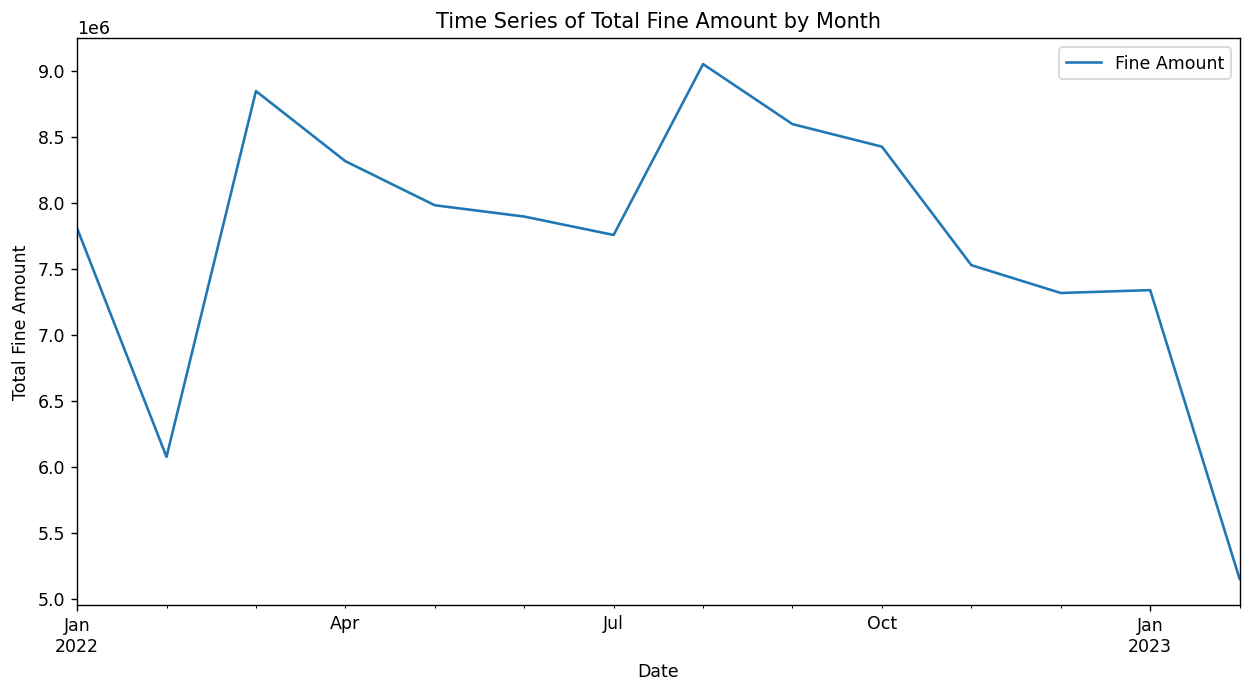

In [62]:
# monthly average of fines

grouped_month_df = df.groupby(pd.Grouper(key='Citation Issued DateTime', freq='M'))['Fine Amount'].sum().reset_index()

grouped_month_df.plot(x='Citation Issued DateTime', y='Fine Amount', figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Month')
plt.show()

The two months with the highest amounts of revenue were March and August, which correspond to the two months with the largest number of parking citations as shown in an earlier plot. This makes sense.

Now, we'll compare revenue on the weekdays vs. the weekends.

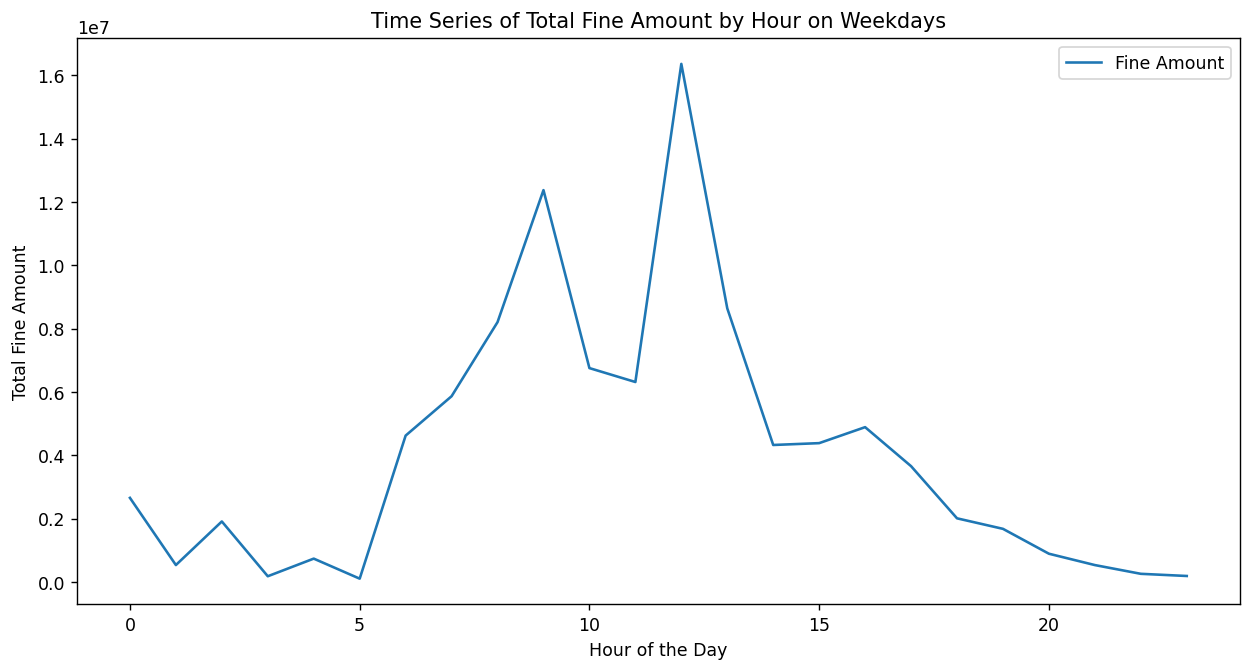

In [63]:
# time series plot of revenue throughout the weekdays

# Now stratify by days of the week.
df['Day of Week'] = df['Citation Issued DateTime'].dt.day_name()

# adding an hour column
df['hour'] = df['Citation Issued DateTime'].dt.hour

# filtering by weekday
grouped_weekday_df = df[df['Day of Week'].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"])]

# summing by hour
grouped_weekday_df = grouped_weekday_df.groupby('hour')['Fine Amount'].sum().reset_index()

# plot
grouped_weekday_df.plot(x='hour', y='Fine Amount', figsize=(12,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Hour on Weekdays')
plt.show()

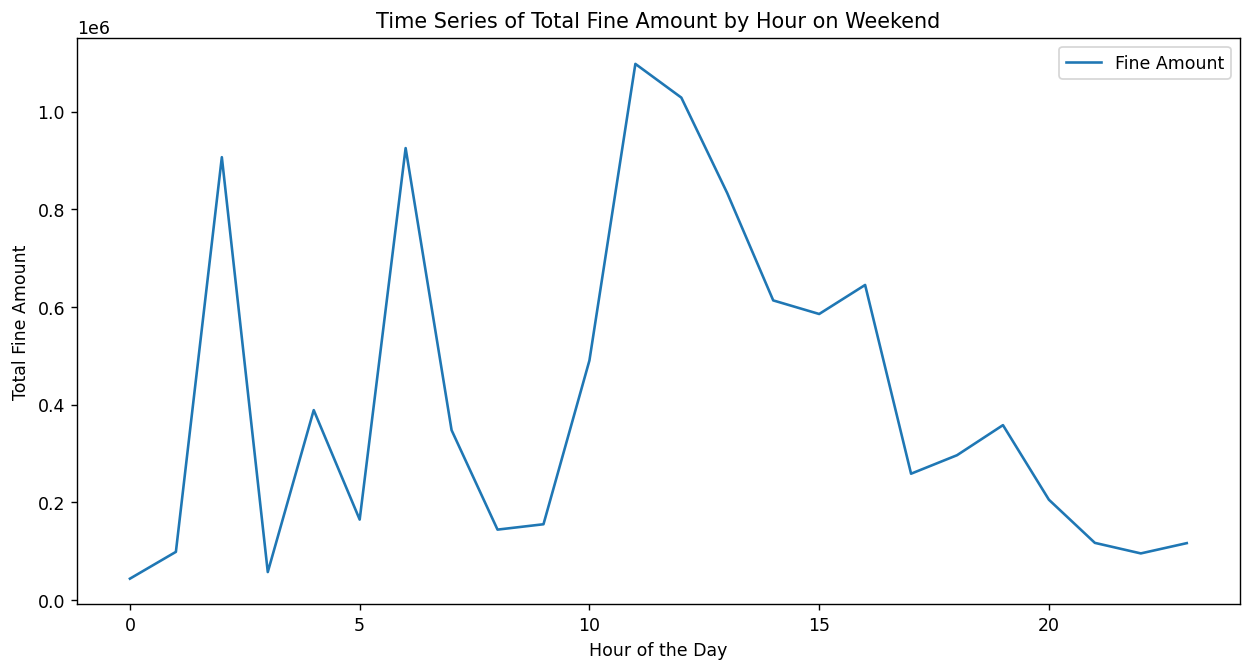

In [64]:
# time series plot of revenue throughout the weekend

# filtering by weekend
grouped_weekend_df = df[df['Day of Week'].isin(["Saturday","Sunday"])]

# summing by hour
grouped_weekend_df = grouped_weekend_df.groupby('hour')['Fine Amount'].sum().reset_index()

# plot
grouped_weekend_df.plot(x='hour', y='Fine Amount', figsize=(12,6))
plt.xlabel('Hour of the Day')
plt.ylabel('Total Fine Amount')
plt.title('Time Series of Total Fine Amount by Hour on Weekend')
plt.show()

These two plots once again confirm our earlier plots, which showed that there were far less tickets being administered on the weekends, so it makes sense that there is way less money made on those days.